In [353]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

import scipy.io as sio
import matplotlib.pyplot as plt
from scipy import misc
import numpy as np
import cv2 
import glob
%matplotlib inline 

# Import test data

In [532]:
data = sio.loadmat('mnist_mix2_gray.mat')
test_data = data['M2']
test_label = data['L2']

print("Test data size: ", test_data.shape)
print("Test label size:", test_label.shape)

Test data size:  (10000, 28, 28)
Test label size: (10000, 2)


In [534]:
np.unique(test_label[:,1])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

## Visualized testing images with label 

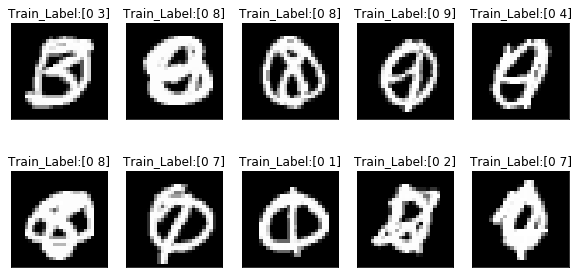

In [439]:
#value = 0 
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1), plt.imshow(test_data[i], 'gray')
    title_text = "Train_Label:" + str(test_label[i])
    plt.xticks([]),plt.yticks([])
    plt.title(title_text, size = 12)
    #value += 500

# Preparing own mixed training dataset using MNIST images

In [682]:
zero, one, two, three, four  =  [],[],[],[],[]
five, six, seven, eight, nine = [],[],[],[],[]
digits = [zero,one,two,three,four,five,six,seven,eight,nine]

## Import images from which are located directory and inserted into digits list 

In [617]:
for i in range(10):
    
    files = glob.glob("..\\MNIST\\mnist_png_data\\training\\%d\\*.PNG" % i)
    for myFile in range(200):
        
        img = misc.imread(files[myFile])
        digits[i].append(img)       

In [618]:
digits = np.array(digits)
digits.shape

(10, 200, 28, 28)

# Mixing two digits images
## Variable declaration 
### 1. I declared train_data array for containing mixed images
### 2. I declared train_label array for containing mixed images' labels 
### 3. Digits array size is [10,200,28,28] details below:
##### First,10 --> 0,1,2...8,9 numbers
##### Second, 200--> samples size for instance 0 have 200, 1 have 200 so on
##### Third, Fourth --> pixel sizes 28x28  
## Proceture of mixing two images 
##### Compared all of the pixels of 2 images. And we can make new combined image which is constructed maximum values. 


In [650]:
train_data = np.zeros(shape=(18000,28,28))
train_label = np.zeros(shape=(18000,2))
loop = 0
i = 0
j = 0
img_count = 0
while(i<10):
    while(j<10):
        if i == j:
            j=j
        else:
            for loop in range(200):
                for x in range(28):
                    for y in range(28):
                        if digits[i,loop,x,y] > digits[j,loop,x,y]:
                            train_data[img_count,x,y] = digits[i,loop,x,y]
                        else:
                            train_data[img_count,x,y] = digits[j,loop,x,y]
                train_label[img_count,0] = i
                train_label[img_count,1] = j
                img_count+=1
            
        j+=1
        loop=0
        x,y =0,0
    i+=1
    j=0
    
train_label= np.uint8(train_label) # float to unsigned int convert 

In [651]:
train_label= np.uint8(train_label)
print(train_data.shape)
print(train_label.shape)

(18000, 28, 28)
(18000, 2)


## Visualized mixed Images with labels

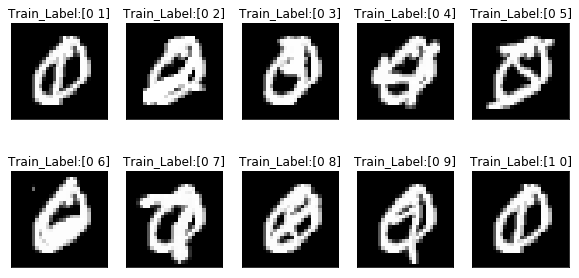

In [653]:
value = 0 
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1), plt.imshow(train_data[value], 'gray')
    title_text = "Train_Label:" + str(train_label[value])
    plt.xticks([]),plt.yticks([])
    plt.title(title_text, size = 12)
    value += 200

# One hot encoder 

In [659]:
from keras.utils import np_utils
test_y1 = np_utils.to_categorical(test_label[:,0])
test_y2 = np_utils.to_categorical(test_label[:,1])

train_y1 = np_utils.to_categorical(train_label[:,0])
train_y2 = np_utils.to_categorical(train_label[:,1])

In [686]:
test_label = test_y1 + test_y2
train_label = train_y1 + train_y2

print("Real value 0, 3")
print("test_y1:    ", test_y1[0])
print("test_y2:    ", test_y2[0])
print("test_label: ", test_label[0])
print("Real value 0, 5")
print("train_y1:   ", train_y1[800])
print("train_y2:   ", train_y2[800])
print("train_label:", train_label[800])


Real value 0, 3
test_y1:     [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
test_y2:     [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
test_label:  [ 1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
Real value 0, 5
train_y1:    [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
train_y2:    [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
train_label: [ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


# Training section

In [673]:
X_train = train_data.reshape(train_data.shape[0], 1, 28, 28).astype('float32')
X_test = test_data.reshape(test_data.shape[0], 1, 28, 28).astype('float32')

In [674]:
X_train.shape

(18000, 1, 28, 28)

In [675]:
X_train = X_train / 255
X_test = X_test / 255
num_classes = test_label.shape[1]
num_classes

10

#### Define neural network model

In [677]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [681]:
# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, train_label, validation_data=(X_test, test_label), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, test_label, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 18000 samples, validate on 10000 samples
Epoch 1/10
 - 33s - loss: 3.0549 - acc: 0.4791 - val_loss: 2.8363 - val_acc: 0.4775
Epoch 2/10
 - 33s - loss: 2.5190 - acc: 0.5152 - val_loss: 2.6153 - val_acc: 0.5040
Epoch 3/10
 - 33s - loss: 2.3391 - acc: 0.5192 - val_loss: 2.5508 - val_acc: 0.5058
Epoch 4/10
 - 33s - loss: 2.2236 - acc: 0.5167 - val_loss: 2.4993 - val_acc: 0.5277
Epoch 5/10
 - 33s - loss: 2.1411 - acc: 0.5208 - val_loss: 2.4295 - val_acc: 0.4815
Epoch 6/10
 - 33s - loss: 2.0654 - acc: 0.5176 - val_loss: 2.4041 - val_acc: 0.4794
Epoch 7/10
 - 33s - loss: 2.0060 - acc: 0.5196 - val_loss: 2.4008 - val_acc: 0.4454
Epoch 8/10
 - 33s - loss: 1.9545 - acc: 0.5197 - val_loss: 2.3688 - val_acc: 0.4810
Epoch 9/10
 - 33s - loss: 1.9188 - acc: 0.5188 - val_loss: 2.3756 - val_acc: 0.4860
Epoch 10/10
 - 33s - loss: 1.8784 - acc: 0.5183 - val_loss: 2.3636 - val_acc: 0.5003
CNN Error: 49.97%
